In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
campaigns_meta  = pd.read_parquet("../../input_data/campaigns_meta.parquet")
categories  = pd.read_parquet("../../input_data/categories.parquet")
camp = pd.read_csv("../../input_data/campaign_stat.csv")

In [3]:
camp.set_index('adv_campaign_id', inplace=True)

In [4]:
campaigns_meta['num_clicks'] = campaigns_meta.goal_budget / campaigns_meta.goal_cost
campaigns_meta['days'] = (campaigns_meta.end_date - campaigns_meta.start_date).astype('timedelta64[ns]').dt.days
campaigns_meta

,adv_campaign_id,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id,num_clicks,days
0,2153,2024-09-21,2024-10-02,6.661659,9429.056096,70,59,1415.421542,11
1,3103,2024-09-10,2024-09-16,2.853378,3844.482933,30,40,1347.344476,6
2,2816,2024-09-10,2024-09-17,3.058230,1455.156612,56,65,475.816538,7
3,3603,2024-09-10,2024-09-16,4.395015,2592.232475,30,50,589.812003,6
4,1328,2024-09-10,2024-09-16,3.891329,2836.139672,30,51,728.835796,6
...,...,...,...,...,...,...,...,...,...
4026,855,2024-09-18,2024-09-24,3.758750,525.462249,12,65,139.797080,6
4027,1781,2024-09-18,2024-09-24,4.122703,3814.655409,46,50,925.280225,6
4028,2485,2024-09-19,2024-09-29,4.004430,3485.343664,57,65,870.371962,10
4029,541,2024-09-20,2024-09-30,9.647247,80305.420249,58,18,8324.180346,10


In [5]:
cat = categories.groupby(['logcat_id']).category_id.agg(pd.Series.mode).astype(int).reset_index()

In [6]:
campaigns_meta = campaigns_meta.merge(cat, on=['logcat_id'], how="left")

In [7]:
catboost_model = CatBoostClassifier()  
catboost_model.load_model("catboost_model_1")

catboost_model1 = CatBoostClassifier()  
catboost_model1.load_model("catboost_model_2")

catboost_model2 = CatBoostClassifier()  
catboost_model2.load_model("catboost_model_3")

catboost_model3 = CatBoostClassifier()  
catboost_model3.load_model("catboost_model_4")

catboost_model4 = CatBoostClassifier()  
catboost_model4.load_model("catboost_model_5")

In [8]:
test_24_9_22 = pd.read_csv("../../input_data/2024-09-22.csv")

test_24_9_22 = test_24_9_22.merge(campaigns_meta[['adv_campaign_id', 'location_id', 'logcat_id',  'num_clicks', 'days', 'category_id']], on=['adv_campaign_id'], how="left")

test_24_9_22['camp'] = test_24_9_22['adv_campaign_id'].map(camp.proportion)

test_24_9_22 = test_24_9_22.fillna(0)

y_24_9_22 = test_24_9_22.target
test_24_9_22 = test_24_9_22.drop(columns=['adv_campaign_id', 'event_date', 'is_main', 'days', 'target', 'Unnamed: 0'])
test_24_9_22 = test_24_9_22.fillna(0)
test_24_9_22.head()

,user_id,platform_id,adv_creative_id,banner_code,location_id,logcat_id,num_clicks,category_id,camp
0,327884,2,1599,8,46,40,1768.568747,4,0.322730
1,1167448,2,2145,5,1,40,4278.102622,4,0.464610
2,3124660,1,4099,7,46,40,1435.407650,4,0.295611
3,770841,3,1026,6,45,18,1755.984136,4,0.444433
4,1714878,2,1869,8,46,25,1349.649447,4,0.461806


In [ ]:
proba_24_9_22 = catboost_model.predict_proba(test_24_9_22)[:, 1]

In [ ]:
proba1_24_9_22 = catboost_model1.predict_proba(test_24_9_22)[:, 1]

In [10]:
proba2_24_9_22 = catboost_model2.predict_proba(test_24_9_22)[:, 1]

In [11]:
proba3_24_9_22 = catboost_model3.predict_proba(test_24_9_22)[:, 1]

In [12]:
proba4_24_9_22 = catboost_model4.predict_proba(test_24_9_22)[:, 1]

In [13]:
proba_frame_24_9_22 = np.concatenate((proba_24_9_22.reshape(-1, 1), proba1_24_9_22.reshape(-1, 1), proba2_24_9_22.reshape(-1, 1), proba3_24_9_22.reshape(-1, 1), proba4_24_9_22.reshape(-1, 1)), axis=1)

stack_result_mean = proba_frame_24_9_22.mean(axis=1)
stack_result_mean

array([0.36521593, 0.73303258, 0.2375475 , ..., 0.44086735, 0.50179059,
       0.64990356])

In [14]:
test_24_9_22['proba'] = stack_result_mean

0.658863326840365


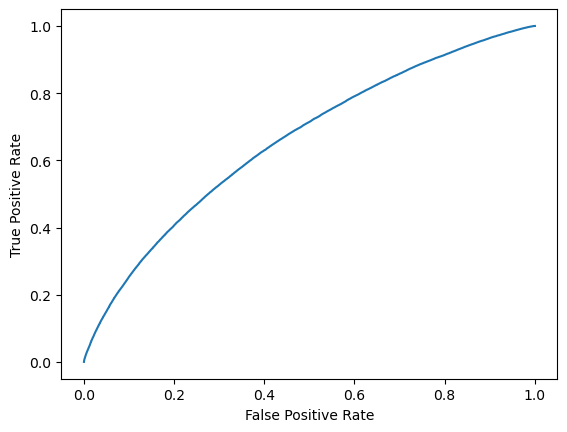

In [15]:
fpr, tpr, thresholds = roc_curve(y_24_9_22, test_24_9_22['proba'])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
print(auc(fpr, tpr))

In [16]:
aucs = []
bad_uid = []

for us in test_24_9_22.user_id.unique():
    
    #if us in train_user:    
    
        tu = test_24_9_22[test_24_9_22.user_id == us]
        uidx = tu.index    
        prob = tu.proba
        fpr, tpr, thresholds = roc_curve(y_24_9_22[uidx], prob)
        ac = auc(fpr, tpr)
        if ac < 0.5: bad_uid.append(us)
        if ~np.isnan(ac): aucs.append(ac) 
        
len(aucs), sum(aucs) / len(aucs)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


(38744, 0.6096113906972925)

In [17]:
test_ = pd.read_parquet("../../input_data/test.parquet")

In [18]:
X_test_ = test_.drop(columns=['event_date'])
X_test_ = X_test_.merge(campaigns_meta[['adv_campaign_id', 'location_id', 'logcat_id',  'num_clicks', 'days', 'category_id']], on=['adv_campaign_id'], how="left").drop(columns=['is_main', 'days'])

In [19]:
X_test_['camp'] = X_test_['adv_campaign_id'].map(camp.proportion)

In [20]:
X_test_ = X_test_.drop(columns=['adv_campaign_id'])

In [21]:
X_test_ = X_test_.fillna(0)

In [ ]:
proba1_ = catboost_model1.predict_proba(X_test_)[:, 1]

In [ ]:
proba2_ = catboost_model2.predict_proba(X_test_)[:, 1]

In [23]:
proba_ = catboost_model.predict_proba(X_test_)[:, 1]

In [24]:
proba3_ = catboost_model3.predict_proba(X_test_)[:, 1]

In [25]:
proba4_ = catboost_model4.predict_proba(X_test_)[:, 1]

In [26]:
proba_frame_ = np.concatenate((proba_.reshape(-1, 1), proba1_.reshape(-1, 1), proba2_.reshape(-1, 1), proba3_.reshape(-1, 1), proba4_.reshape(-1, 1)), axis=1)

stack_result = proba_frame_.mean(axis=1)
stack_result

array([0.67966639, 0.56659026, 0.68042057, ..., 0.62538614, 0.76607382,
       0.59046118])

In [27]:
test_['predict'] = stack_result.astype('float64')

In [28]:
test_[["user_id", "adv_campaign_id", "predict"]].to_csv("stacking_5_0.6096113906972925.csv", index=False)

In [32]:
test_

,user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,predict
0,2714742,3026,2,4056,2024-09-23,8,True,0.672874
1,2714742,2994,2,3954,2024-09-23,8,True,0.559617
2,2714742,97,2,1752,2024-09-23,8,True,0.667370
3,2714742,3539,2,1244,2024-09-23,8,True,0.646260
4,2714742,2756,2,2003,2024-09-23,8,True,0.731680
...,...,...,...,...,...,...,...,...
1983282,2398626,1099,2,3030,2024-09-23,8,True,0.649754
1983283,2398626,488,2,1324,2024-09-23,8,True,0.711635
1983284,2398626,49,2,1514,2024-09-23,8,True,0.639494
1983285,2398626,1053,2,4211,2024-09-23,5,False,0.754314
